In [76]:
import sympy as sp
from sympy import lambdify
import numpy as np
import matplotlib.pyplot as plt

class FEMBasis(object):
    """This is gonna be my class for all the basis functions"""
    def __init__(this, x, N):
        """Takes a sympy symbol and the 1-D Mesh size, higher dimensions can be created via Kronecker delta product"""
        if isinstance(x, sp.Symbol):
            h = sp.Rational(1, N-1)
        else:
            h = 1.0/(N-1)
        this.h = 1.0/(N-1)
        this.points = [i*h for i in range(N)]
        this.psi = [this.Lagrange_polynomial(x, i, this.points) for i in range(N)]
        this.lam_psi = [] ## convert all them sympy expressions into sweet organic lambdas
        for i in range(0,len(this.psi)):
            this.lam_psi.append(lambdify(x, this.psi[i], modules=['numpy']))
        this.lam_dpsi = [] ## again but the derivatives
        for i in range(0,len(this.psi)):
            this.lam_dpsi.append(lambdify(x, sp.diff(this.psi[i]), modules=['numpy']))


        
    def Lagrange_polynomial(this, x, i, points):
        """Makes the Lagrange polynomial specified"""
        p = 1
        for k in range(len(points)):
            if k != i:
                p *= (x - points[k])/(points[i] - points[k])
        return p
    
    def integrate(this,f,a,b,N):
        """integrates f using Chebyshev-Gauss Quadrature"""
        xi = np.cos(np.pi*(1-np.linspace(0,1,N+1))) ## [-1,1] Chebyshev points
        wi = np.pi/N*(1-xi**2)**0.5 ## weights
        xi = a+(b-a)*(xi+1.0)/2.0 ## mapping to interval [a,b]
        wi*=(b-a)/2.0 ## adjusting weights to reflect mapped domain
        return(sum(wi*f(xi)))

    def innerproduct(this,f,g,a,b,N):
        """inner product of two functions f & g"""
        return(this.integrate(lambda x: f(x)*g(x),a,b,N))
    
    def makeA(this):
        """integrate psi_i psi_j"""
        this.A = []    
        for i in range(0,len(this.lam_psi)):
            row = []
            for j in range (0,len(this.lam_psi)):
                row.append(this.innerproduct(this.lam_psi[i],this.lam_psi[j],0,1,100))
            this.A.append(row)
                        
    def makeU(this):
        """integrate psi_i dpsi_j"""
        this.K = []    
        for i in range(0,len(this.lam_psi)):
            row = []
            for j in range (0,len(this.lam_dpsi)):
                row.append(this.innerproduct(this.lam_psi[i],this.lam_dpsi[j],0,1,100))
            this.K.append(row)       
            
    def makeK(this):
        """integrate dpsi_i dpsi_j"""
        this.K = []    
        for i in range(0,len(this.lam_dpsi)):
            row = []
            for j in range (0,len(this.lam_dpsi)):
                row.append(this.innerproduct(this.lam_dpsi[i],this.lam_dpsi[j],0,1,100))
            this.K.append(row)
            
    def makeVecB(this, f):
        """integrate psi_i f for given f"""  
        this.vecB = []
        for i in range(0,len(this.lam_psi)):
            this.vecB.append(this.innerproduct(this.lam_psi[i],f,0,1,100))

In [85]:
x = sp.symbols('x')
myFEM = FEMBasis(x,5)

In [104]:
myFEM.makeVecB(lambda x: x**2)

In [105]:
myFEM.makeA()
myFEM.makeK()

In [106]:
np.dot(myFEM.A,myFEM.vecB) 

array([ 0.00324707,  0.02166304, -0.01619762,  0.07311339,  0.01516982])

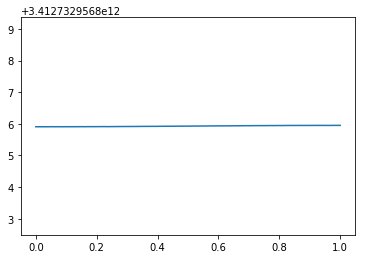

In [107]:
u = np.dot(np.linalg.inv(myFEM.K), np.dot(myFEM.A,myFEM.vecB) )
u

myF = lambda x: u[0]*myFEM.lam_psi[0](x)+u[1]*myFEM.lam_psi[1](x)+u[2]*myFEM.lam_psi[2](x)+u[3]*myFEM.lam_psi[3](x)+u[4]*myFEM.lam_psi[4](x)
x_i = np.linspace(0,1,100)
plt.plot(x_i,myF(x_i))
plt.show()

In [103]:
diag = np.ones(10)
diag[0] = 0
diag[len(diag)-1] = 0
diag
np.dot(myFEM.K,np.diag(diag))

ValueError: shapes (5,5) and (10,10) not aligned: 5 (dim 1) != 10 (dim 0)

In [81]:
u = np.dot(np.linalg.inv(myFEM.A), npmyFEM.vecB) 

In [82]:
u

array([  5.88418203e-15,   1.23456790e-02,   4.93827160e-02,
         1.11111111e-01,   1.97530864e-01,   3.08641975e-01,
         4.44444444e-01,   6.04938272e-01,   7.90123457e-01,
         1.00000000e+00])

In [83]:
sqr = [(0.1*x)**2 for x in range(1,11)]

In [84]:
sqr

[0.010000000000000002,
 0.04000000000000001,
 0.09000000000000002,
 0.16000000000000003,
 0.25,
 0.3600000000000001,
 0.4900000000000001,
 0.6400000000000001,
 0.81,
 1.0]